<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/report/SmoothGRADImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading in Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive

Mounted at /content/drive
 cbcdiagram.png			  qexample.jpg
'Colab Notebooks'		  SmoothGradImplementation.ipynb
 ComparisonCopyYoussef_v2.ipynb   SmoothGradIntro.ipynb
 cryptologywriteup.ipynb	  toyexample.jpg
 dst				  VanillaGradIntro.ipynb
'Moral essay.gdoc'		  VanillaGrad.png


In [2]:
!unzip "/content/drive/MyDrive/dst/archive.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/dst/archive.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(21

**Imports**

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import pearsonr

Loaded image: /content/data/Training/no_tumor/image(206).jpg


(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

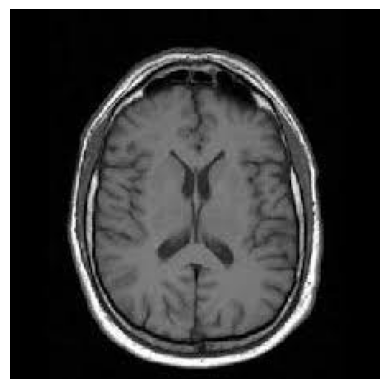

In [4]:
root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


Dataset has now been loaded in. Now we need to transform the images by resizing and ToTensor and make dataloaders.

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Simple CNN**

In this intro to SmoothGrad file we are using a Simple CNN to examine it's stability compared to baseline method VanillaGrad. In the final comparison to the other interpretability methods, we will use the fully trained CNN we built.

In [7]:
class SimpleCNN(nn.Module):
    # 2 convolutional layers
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 64),
            nn.ReLU(),
            nn.Linear(64, len(train_dataset.classes)),
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [8]:
model = SimpleCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
# training the simple CNN
epochs = 10

for epoch in range(epochs):
    model.train()               # set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{epochs}]  "
          f"Loss: {avg_loss:.4f}  "
          f"Acc: {train_accuracy:.2f}%")


Epoch [1/10]  Loss: 1.1959  Acc: 48.26%
Epoch [2/10]  Loss: 0.8682  Acc: 64.04%
Epoch [3/10]  Loss: 0.7043  Acc: 70.80%
Epoch [4/10]  Loss: 0.6077  Acc: 74.74%
Epoch [5/10]  Loss: 0.5562  Acc: 78.01%
Epoch [6/10]  Loss: 0.5056  Acc: 80.03%
Epoch [7/10]  Loss: 0.4701  Acc: 81.71%
Epoch [8/10]  Loss: 0.4318  Acc: 83.90%
Epoch [9/10]  Loss: 0.3998  Acc: 84.60%
Epoch [10/10]  Loss: 0.3838  Acc: 85.19%


In [10]:
torch.save(model.state_dict(), "simplecnn_mri.pth")
model.load_state_dict(torch.load("simplecnn_mri.pth", map_location=device))

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total * 100
print("Test Accuracy:", test_acc)


Test Accuracy: 55.0761421319797


**SmoothGrad Implementation**

In [11]:
def compute_smoothgrad(model, image_tensor, target_class, device,
                       n_samples=50, stdev=0.15, magnitude=True):
    """
    SmoothGrad implementation.
    Adds Gaussian noise to input and averages gradient saliency.
    Choose sigma=0.15 for reasons shown in SmoothGrad intro
    """

    model.eval()

    # Convert input to numpy for noise sampling
    x_np = image_tensor.clone().detach().cpu().numpy()
    img_min, img_max = x_np.min(), x_np.max()
    noise_std = stdev * (img_max - img_min)

    total_gradients = np.zeros_like(x_np)

    for i in range(n_samples):

        # Add Gaussian noise
        noise = np.random.normal(0, noise_std, size=x_np.shape).astype(np.float32)
        noisy_input = x_np + noise

        noisy_tensor = torch.from_numpy(noisy_input).to(device)
        noisy_tensor.requires_grad_(True)

        # Forward
        output = model(noisy_tensor)
        score = output[0, target_class]

        # Backward
        model.zero_grad()
        score.backward()

        grads = noisy_tensor.grad.detach().cpu().numpy()

        # Accumulate gradients
        if magnitude:
            total_gradients += grads * grads
        else:
            total_gradients += np.abs(grads)

    # Average
    avg_grad = total_gradients[0] / n_samples  # remove batch dim
    saliency = np.max(avg_grad, axis=0)

    # Normalise [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency

The importance of $\sigma $:

When we add Gaussian noise to each pixel realisation $x$, we add it by:

$$x_i = x + \epsilon_i,      $$ where $$\epsilon_i \sim \mathcal{N}(0, \sigma^2).$$

In this simulation, I randomly sampled images from the set and produced their saliency maps after adding various levels of Gaussian noise.

I have selected 3 in particular here to showcase SmoothGrad's perfomance.

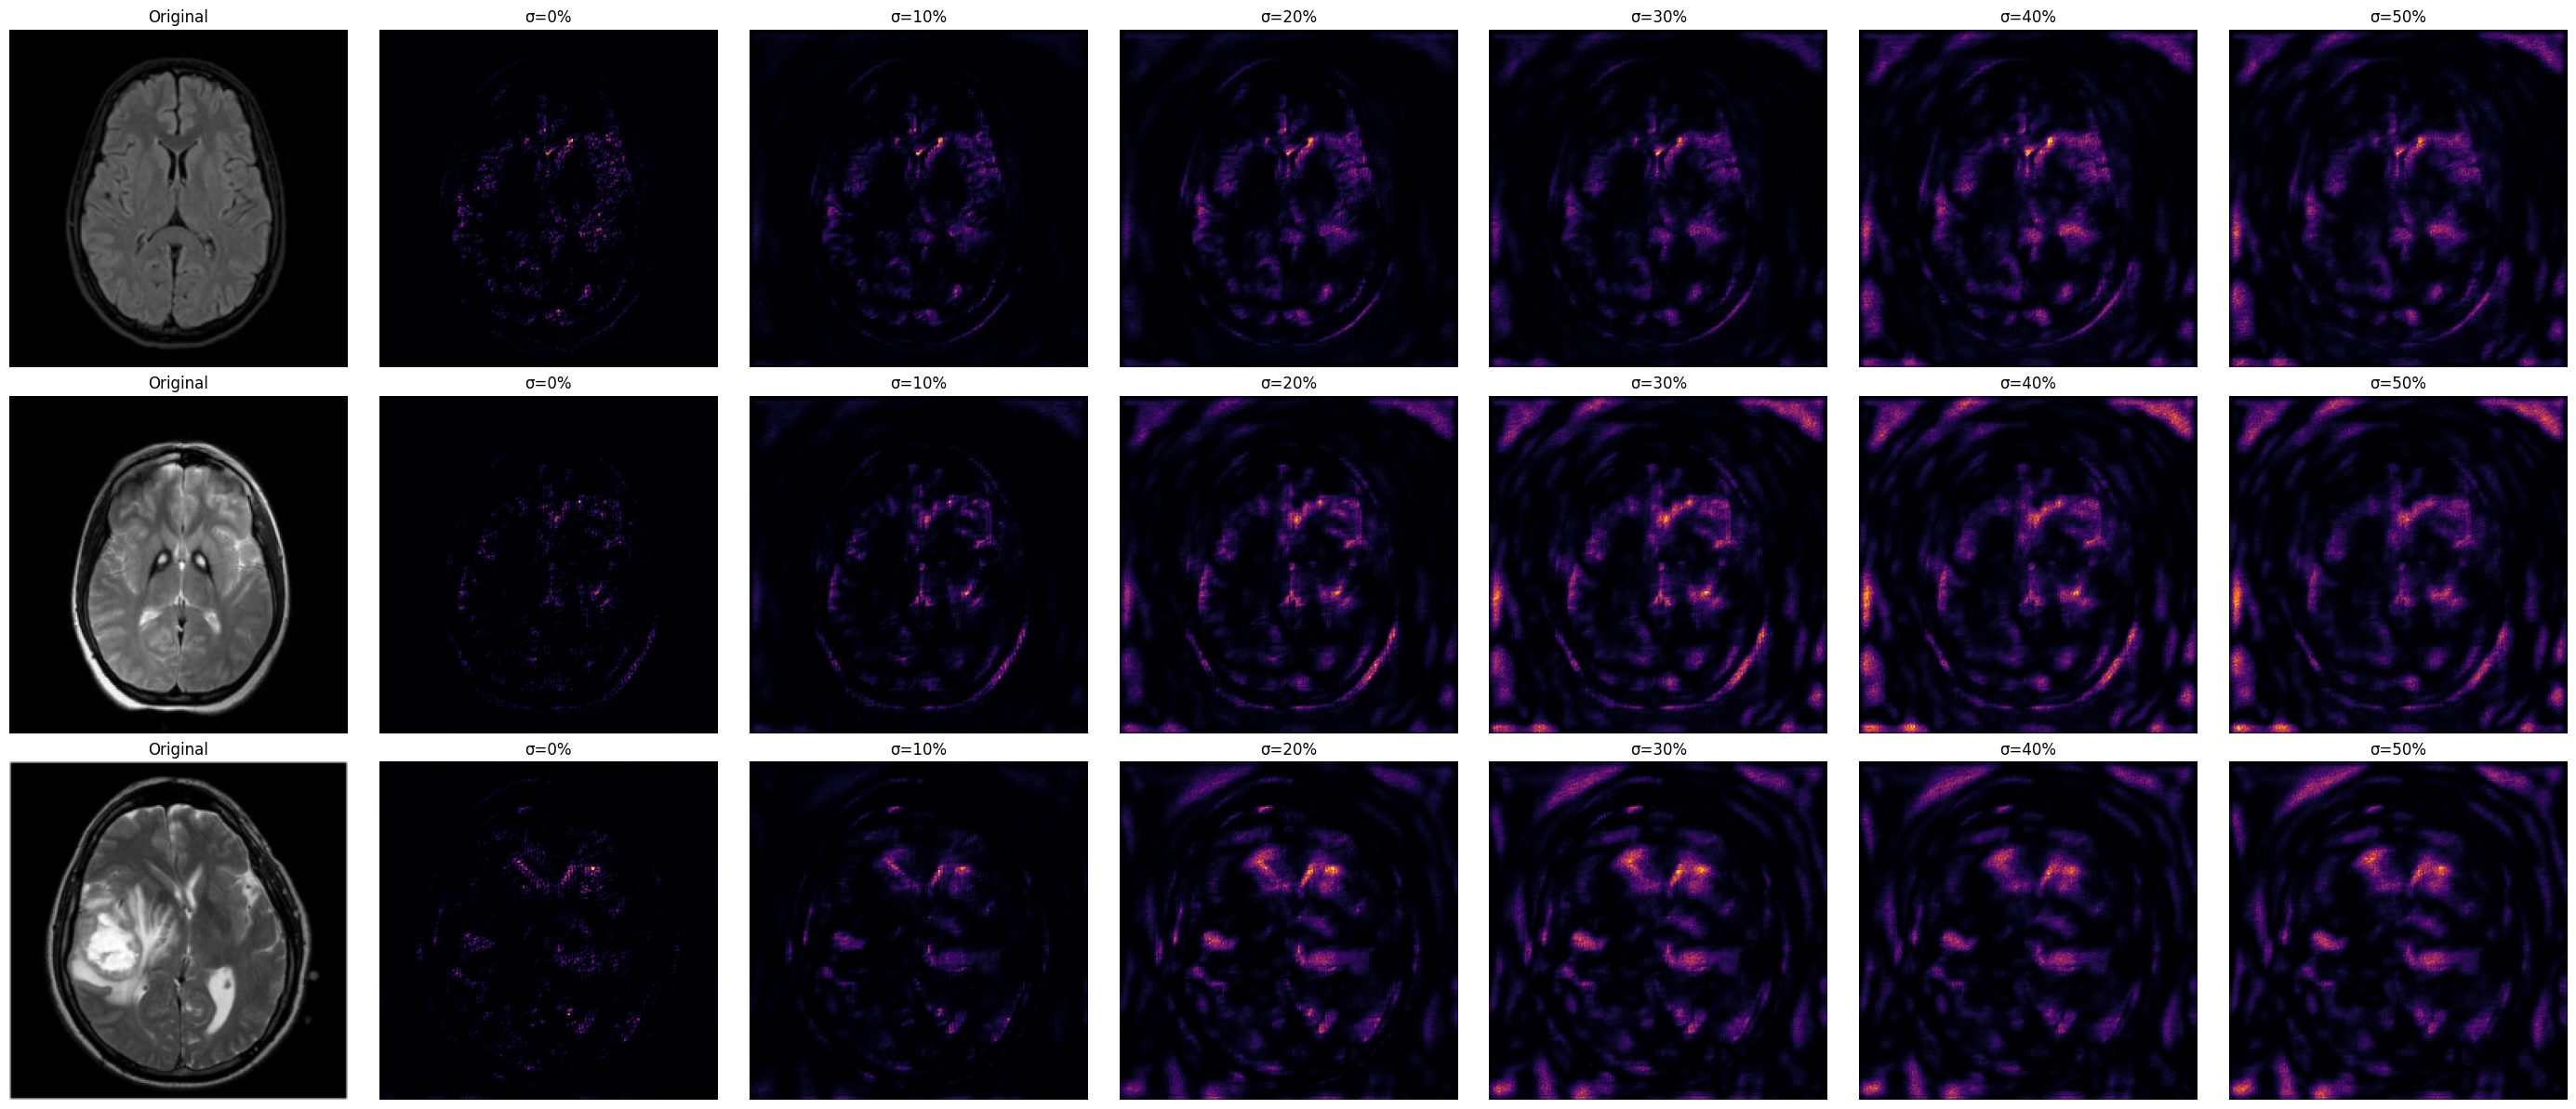

In [12]:
sigma_values = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50]

def sigma_simulations(sigma_values):
  example_imgs = []
  example_labels = []

  # choose 3 random images to compare
  # Making note of indices that show patterns: [217, 292, 20]
  #indices = random.sample(range(len(test_dataset)), 3)
  indices = [217, 292, 20]
  # print(indices)

  for idx in indices:
      img, label = test_dataset[idx]
      example_imgs.append(img.unsqueeze(0))  # make shape [1,3,224,224]
      example_labels.append(label)

  all_smoothgrads = []

  for img, label in zip(example_imgs, example_labels):
      img = img.to(device)
      img_sgs = {}

      for sigma in sigma_values:

          sg_map = compute_smoothgrad(
              model, img, label, device,
              n_samples=50,
              stdev=sigma
          )

          img_sgs[sigma] = sg_map

      all_smoothgrads.append(img_sgs)

  num_imgs = len(example_imgs)
  num_sigmas = len(sigma_values)

  fig, axs = plt.subplots(num_imgs, num_sigmas+1, figsize=(4*(num_sigmas+1), 4*num_imgs))

  for row in range(num_imgs):

      original = example_imgs[row][0].permute(1,2,0).cpu().numpy()
      axs[row, 0].imshow(original)
      axs[row, 0].set_title("Original")
      axs[row, 0].axis("off")

      # Fill in SmoothGrad maps
      for col, sigma in enumerate(sigma_values, start=1):
          axs[row, col].imshow(all_smoothgrads[row][sigma], cmap='inferno')
          axs[row, col].set_title(f"σ={int(sigma*100)}%")
          axs[row, col].axis("off")

  plt.tight_layout()
  plt.show()

  return None

sigma_simulations(sigma_values)


We can see from this output that at $\sigma = 0$, there isn't much definition in our saliency map. This is equivalent to the vanilla saliency map.

As $\sigma$ increases, structures in the image become more clear, but we can see the maps getting hazier and picking up on structures not in the original image as $\sigma$ passes its optimal value.

Take the 3rd row for example: we can see there's a highlighted section on the left hand side of the brain. At values of $σ = ${$0.1, 0.2, 0.3$} this region is highlighted in the map, showing SmoothGrad is working. But as we get to $50%$ we can see that SmoothGrad is printing oval structures around the shape of the head - this isn't originally there and is a false prediction due to the excess noise.

Using these maps, the optimal value looks to be between 10 and 20%, but let's check closer.

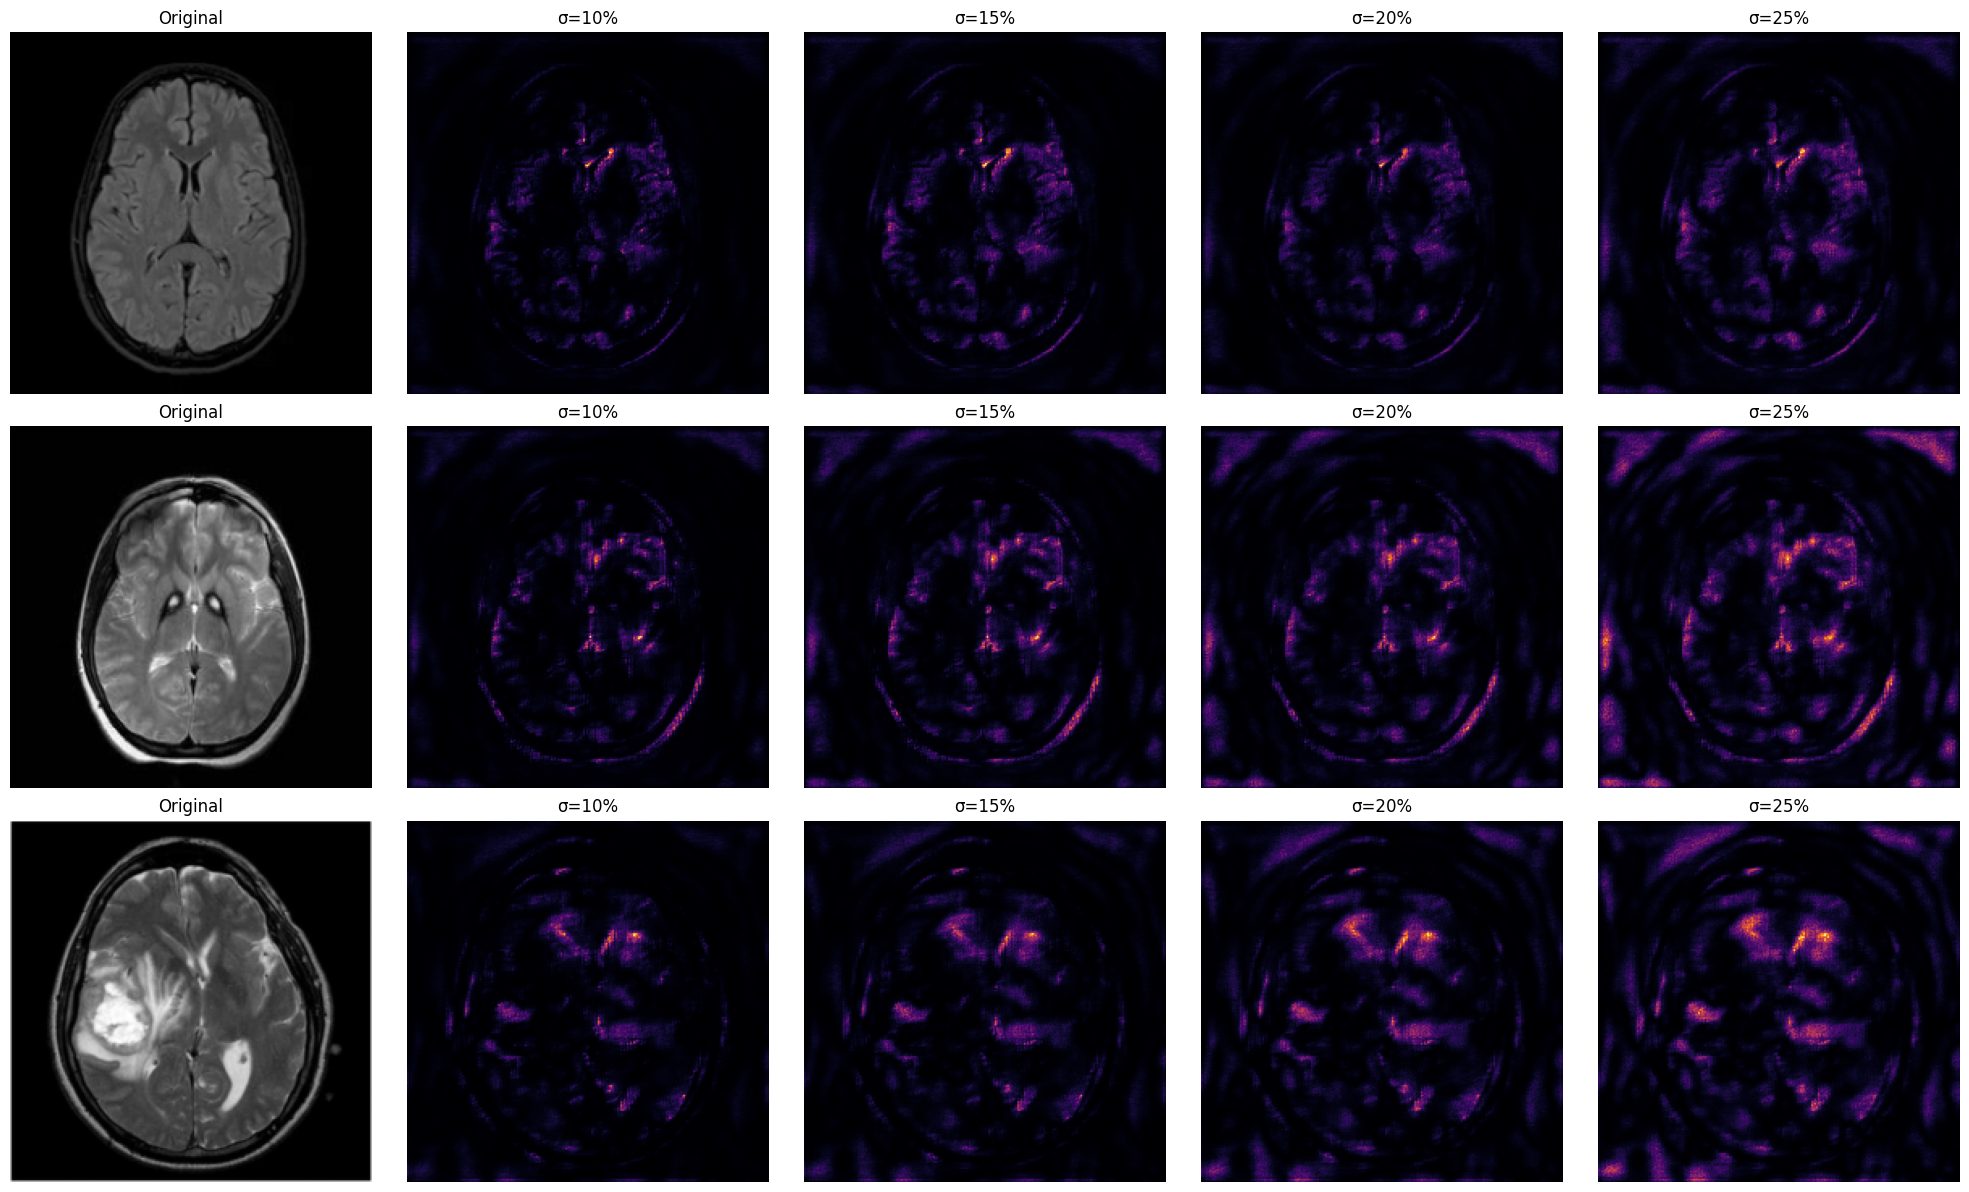

In [13]:
sigma_values = [0.10, 0.15, 0.20, 0.25]

sigma_simulations(sigma_values)


As we thought, 25% is too high and irrelevant structures are appearing in the map. 15% seems to be the perfect combination of highlighting the structures without adding any noise.

**Evaluating SmoothGrad's Stability:**

To best display SmoothGrad's improvement in stability, we have opted to compare it to Vanilla Grad as a baseline. Below is a simple VanillaGrad implementation and a visualisation of their saliency maps for a randomly sampled image.

In [14]:
def compute_vanilla_saliency(model, image_tensor, target_class, device):
    """
    Compute vanilla gradient saliency map for a single input image.
    image_tensor: shape [1, C, H, W]
    """

    model.eval()
    image_tensor = image_tensor.clone().detach().to(device)
    image_tensor.requires_grad_(True)

    # Forward pass - computes logits f(x)
    output = model(image_tensor)
    score = output[0, target_class]

    # Backward pass - compute gradient at target class
    model.zero_grad()
    score.backward()
    grads = image_tensor.grad.detach().cpu().numpy()[0]

    # Reduce channels to 2d
    saliency = np.max(np.abs(grads), axis=0)

    # Normalise to [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency


In [15]:
def show_saliency_comparison(original_img, vanilla_map, smoothgrad_map):
    fig, axs = plt.subplots(1, 3, figsize=(16,5))

    axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title("Original MRI")
    axs[0].axis('off')

    axs[1].imshow(vanilla_map, cmap='gray')
    axs[1].set_title("Vanilla Gradient Saliency")
    axs[1].axis('off')

    axs[2].imshow(smoothgrad_map, cmap='gray')
    axs[2].set_title("SmoothGrad Saliency")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


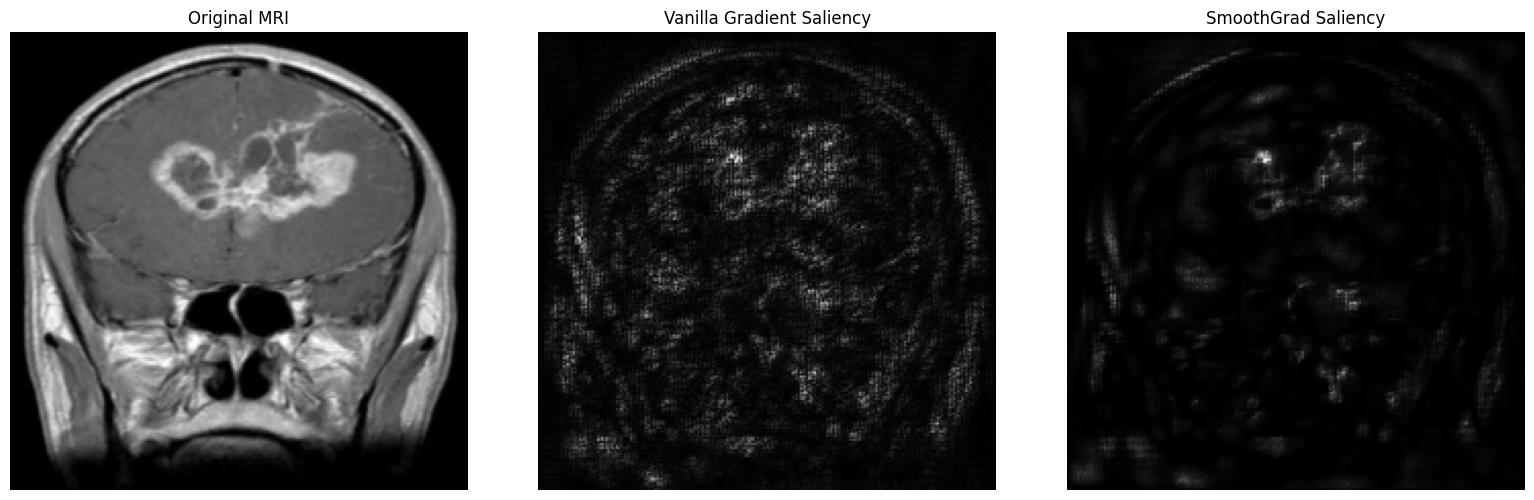

In [16]:
# Prepare a test image
images, labels = next(iter(test_loader))

img = images[0].unsqueeze(0).to(device)   # [1,3,224,224]
target_class = labels[0].item()

# Compute saliency maps
vanilla_map = compute_vanilla_saliency(model, img, target_class, device)
smooth_map  = compute_smoothgrad(model, img, target_class, device,
                                 n_samples=50, stdev=0.15)

# Visualise
show_saliency_comparison(
    original_img = images[0].permute(1,2,0).cpu().numpy(),
    vanilla_map = vanilla_map,
    smoothgrad_map = smooth_map
)


On the right we can clearly see the shapes of the tumor area coming through - the loops in the highlighted region are much clearer in the SmoothGrad saliency map. They are also the only noticeable feature in the SmoothGrad map, which shows the model is correctly identifying important parts rather than just printing everything it sees like Vanilla.

**Adding Pertubation to Investigate Robustness of Methods:**

SmoothGrad improves predictive power by adding internal Gaussian noise to multiple realisations of the original image $x$ and averaging across the ensemble, but what happens if we add external Gaussian noise $𝜍$ ? This is a pertubation producing a new image $x'$ and demonstrates the robustness of each technique.

$$ x' = x + 𝜍$$

Assuming SmoothGrad is more stable than VanillaGrad as we should expect, the saliency map should be less sensitive to this change than VanillaGrad. To compare the quantitatively rather than just what we think *looks* most stable, we have chosen stability metrics L2 and Pearson Correlation.


**L2 Distance:**

The L2 distance measures the absoloute change in the saliency values between two saliency maps $S_1$ and $S_2$ (here between the methods on images $x$ and $x'$).

$$ || S_1 - S_2 ||_2 = \sqrt{∑_i (S_1 - S_2)^2}$$.

A small L2 distance indicates that the method is stable since the map is less sensitive to the noise. Therefore, we expect L2(SmoothGRAD) < L2(VanillaGRAD).


**Pearson Correlation Coefficient**

The CC measures the similarity between the shapes of the saliency maps rather than size of the similarity like L2 distance. It does this by breaking down the map by pixel and comparing all in the sum:

$$CC(S_1,S_2)=\frac{\text{cov}(S_1,S_2)}{\sigma_{S_1}\sigma_{S_2}} =\frac{\sum_{i=1}^n(S_{1,i}-\bar{S}_1)(S_{2,i}-\bar{S}_2)}{\sqrt{\sum_{i=1}^n(S_{1,i}-\bar{S}_1)^2}\sqrt{\sum_{i=1}^n(S_{2,i}-\bar{S}_2)^2}} ∈ [-1, 1]
$$

This complements L2 distance since we want to check whether both the magnitude and structures of the saliency map change. Therefore a large positive correlation means the technique is stable, so we shoudl expect SmoothGrad to have a larger CC than VanillaGrad.

I am only adding 5% to see the impact.


In [17]:
def apply_small_perturbation(img_tensor, noise_std=0.05):
    """
    Applies a tiny Gaussian perturbation to test saliency stability.
    Note this is external not internal - not the same as how SmoothGrad uses Gaussian noise.
    """
    noise = torch.randn_like(img_tensor) * noise_std
    return img_tensor + noise


In [18]:
def compute_stability_metrics(map_original, map_perturbed):
    """
    Computes L2 distance and Pearson correlation between saliency maps.
    Higher correlation + lower L2 = more stable explanations.
    """
    flat_o = map_original.flatten()
    flat_p = map_perturbed.flatten()

    l2 = np.linalg.norm(flat_o - flat_p)
    corr = pearsonr(flat_o + 1e-8, flat_p + 1e-8)[0]  # numerical stability

    return l2, corr


In [19]:
def run_stability_experiment(model, img, target_class, device, noise_std=0.02):

    img_tensor = img.unsqueeze(0).to(device)

    # Original saliency maps
    vanilla_orig = compute_vanilla_saliency(model, img_tensor, target_class, device)
    smooth_orig  = compute_smoothgrad(model, img_tensor, target_class, device)

    # Apply external input perturbation (not SmoothGrad noise)
    img_pert = apply_small_perturbation(img_tensor, noise_std=noise_std)

    # Perturbed saliency maps
    vanilla_pert = compute_vanilla_saliency(model, img_pert, target_class, device)
    smooth_pert  = compute_smoothgrad(model, img_pert, target_class, device)

    # Compute quantitative stability
    v_l2, v_corr = compute_stability_metrics(vanilla_orig, vanilla_pert)
    s_l2, s_corr = compute_stability_metrics(smooth_orig, smooth_pert)

    return {
        "vanilla_l2": v_l2, "vanilla_corr": v_corr,
        "smooth_l2":  s_l2, "smooth_corr":  s_corr,
        "vanilla_maps": (vanilla_orig, vanilla_pert),
        "smooth_maps":  (smooth_orig, smooth_pert)
    }


In [20]:
# Pick a random test image
idx = np.random.randint(0, len(test_dataset))
img, label = test_dataset[idx]

target_class = label

results = run_stability_experiment(model, img, target_class, device)


In [21]:
print("VanillaGrad Stability:")
print("  L2 distance: ", results["vanilla_l2"])
print("  Correlation:", results["vanilla_corr"])

print("\nSmoothGrad Stability:")
print("  L2 distance: ", results["smooth_l2"])
print("  Correlation:", results["smooth_corr"])

VanillaGrad Stability:
  L2 distance:  11.266863
  Correlation: 0.8079219

SmoothGrad Stability:
  L2 distance:  3.9703526
  Correlation: 0.95300037


Our results are as we expected. SmoothGrad achieves a lower L2 distance and greater positive correlation coefficient than VanillaGrad, indicating it is a more stable technique which preserves the saliency map's structure better under noise pertubation.

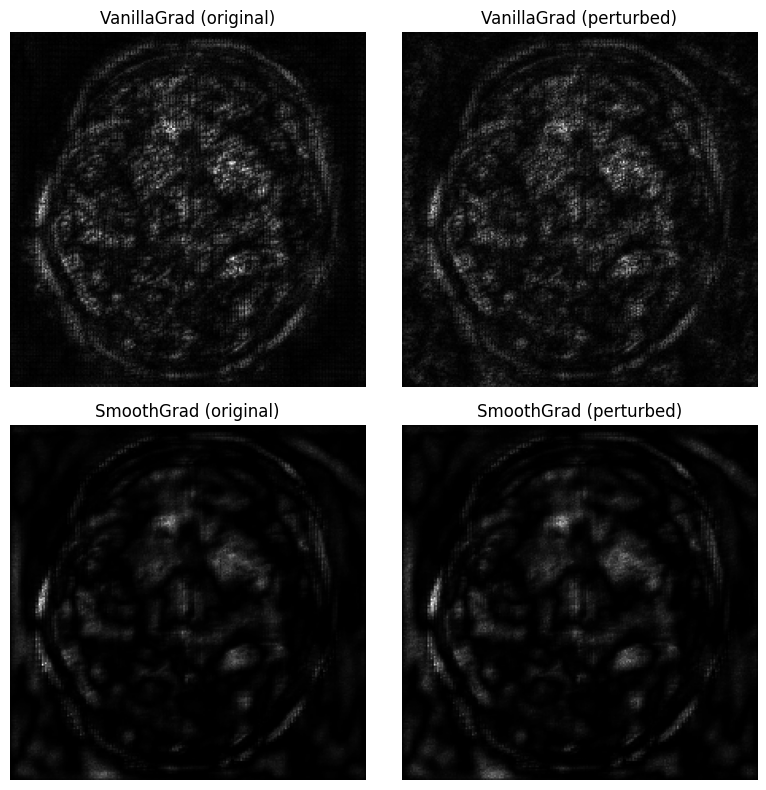

In [22]:
vanilla_orig, vanilla_pert = results["vanilla_maps"]
smooth_orig, smooth_pert   = results["smooth_maps"]

fig, axs = plt.subplots(2, 2, figsize=(8,8))

axs[0,0].imshow(vanilla_orig, cmap="gray")
axs[0,0].set_title("VanillaGrad (original)")
axs[0,0].axis("off")

axs[0,1].imshow(vanilla_pert, cmap="gray")
axs[0,1].set_title("VanillaGrad (perturbed)")
axs[0,1].axis("off")

axs[1,0].imshow(smooth_orig, cmap="gray")
axs[1,0].set_title("SmoothGrad (original)")
axs[1,0].axis("off")

axs[1,1].imshow(smooth_pert, cmap="gray")
axs[1,1].set_title("SmoothGrad (perturbed)")
axs[1,1].axis("off")

plt.tight_layout()
plt.show()


In the Vanilla Grad saliency maps, we can see that the perturbed version is much hazier, demonstrating its sensitivity to noise. SmoothGrad on the other hand looks basically unchanged.

**Conclusion**

From all of the outputs presented above, we have demonstrated the effectiveness of SmoothGrad in smoothing out VanillaGrad's speckly saliency maps, and proved it is more robust to external noise than VanillaGrad. We also found the optimal level of Gaussian noise to add to be $15$%.